# 👮 Boston crime analysis
---

The goal of this study is to get an improved understanding of the offences that happen in Boston in order to enhance the policing strategy. We are going to answer the following questions :
- 🕑 What are the times and days are most affected by crime in Boston ?
- 🚨 What are the most frequent crimes in Boston ?
- 🗺️ Visualize using a map the amount of crimes depending their locations.

In order to do this, we will use the following [dataset](https://raw.githubusercontent.com/Rgts/Datasets/main/boston_crimes_2016_02.csv) made from governmental data.

> 🧰 Let's first import all the packages that we will need for this study.

In [367]:
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

## 👷 0. Dataset preparation
---

Let's firstly take a look at our dataset in order to identify and organize the data that will help us in this study.

In [368]:
# Load the dataset from the previously downloaded file
df = pd.read_csv("../data/boston_crimes_2016_02.csv")

# Show the first rows to have an idea of what the data looks like
df.head(3)

,Object,District,Date,Day,Hour,Latitude,Longitude
0,Fraud,D4,2016-02-01 08:00:00,Monday,8,42.337403,-71.082215
1,Fraud,B3,2016-02-01 00:00:00,Monday,0,42.296063,-71.086648
2,Fraud,C11,2016-02-02 11:00:00,Tuesday,11,42.306480,-71.066758


In [369]:
df.shape

(6803, 7)

There are not much columns and they all might help us in this study, we won't remove any of them for now. What could help us when drawing our next graphs whould be settings the `Day` column as categorical for keeping an order.

In [370]:
df["Day"] = pd.Categorical(df["Day"], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

In [371]:
df["Object"].unique()

array(['Fraud', 'Property Lost', 'Investigate Person',
       'Missing Person Reported', 'Larceny From Motor Vehicle',
       'Harassment', 'Counterfeiting', 'Other',
       'Police Service Incidents', 'Confidence Games', 'Larceny',
       'Warrant Arrests', 'Vandalism', 'Missing Person Located',
       'Motor Vehicle Accident Response', 'Auto Theft',
       'Residential Burglary', 'Investigate Property', 'Robbery',
       'Embezzlement', 'Restraining Order Violations',
       'Disorderly Conduct', 'Landlord/Tenant Disputes',
       'Medical Assistance', 'License Plate Related Incidents',
       'Violations', 'Towed', 'Property Found', 'Aggravated Assault',
       'Firearm Discovery', 'Liquor Violation', 'Simple Assault',
       'Property Related Damage', 'Verbal Disputes', 'Firearm Violations',
       'Fire Related Reports', 'Drug Violation', 'Evading Fare',
       'Ballistics', 'Assembly or Gathering Violations',
       'Auto Theft Recovery', 'License Violation',
       'Operating Un

⚠️ Seeing the different values that are present in our `Object` column, it looks like our dataset is more of a "police intervention" dataset than a "crime dataset". Let's create a `crime_df` that contains crime related interventions. For this, we will consider that objects in `Property Lost, Investigate Person, Missing Person Located, Motor Vehicle Accident Response, Investigate Property, Medical Assistance, Property Found, Search Warrants, Recovered Stolen Property, Phone Call Complaints, , Other` are NOT crimes.

In [372]:
crime_df = df.loc[~df["Object"].isin(["Property Lost", "Investigate Person", "Missing Person Located",
                            "Motor Vehicle Accident Response", "Investigate Property", "Medical Assistance",
                            "Property Found", "Search Warrants", "Recovered Stolen Property",
                            "Phone Call Complaints", "Service", "Other"])]
crime_df["Object"].unique()

array(['Fraud', 'Missing Person Reported', 'Larceny From Motor Vehicle',
       'Harassment', 'Counterfeiting', 'Police Service Incidents',
       'Confidence Games', 'Larceny', 'Warrant Arrests', 'Vandalism',
       'Auto Theft', 'Residential Burglary', 'Robbery', 'Embezzlement',
       'Restraining Order Violations', 'Disorderly Conduct',
       'Landlord/Tenant Disputes', 'License Plate Related Incidents',
       'Violations', 'Towed', 'Aggravated Assault', 'Firearm Discovery',
       'Liquor Violation', 'Simple Assault', 'Property Related Damage',
       'Verbal Disputes', 'Firearm Violations', 'Fire Related Reports',
       'Drug Violation', 'Evading Fare', 'Ballistics',
       'Assembly or Gathering Violations', 'Auto Theft Recovery',
       'License Violation', 'Operating Under the Influence', 'Bomb Hoax',
       'Harbor Related Incidents', 'Prisoner Related Incidents',
       'Commercial Burglary', 'Offenses Against Child / Family',
       'Manslaughter', 'Other Burglary', 'Ars

### ⚠️ 0.1 Data cleaning
---

Let's check if there is any NaN or empty value in our dataset.

In [373]:
# Check if there is any NaN value
crime_df[crime_df.isna().any(axis=1)]

,Object,District,Date,Day,Hour,Latitude,Longitude


In [374]:
# Check if there is any null value
crime_df[crime_df.isnull().any(axis=1)]

,Object,District,Date,Day,Hour,Latitude,Longitude


In [375]:
# Remove whitespaces in column names
crime_df.rename(columns=lambda x: x.strip(), inplace=True)

/tmp/ipykernel_90845/1219866585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df.rename(columns=lambda x: x.strip(), inplace=True)


## 1. 🧰 What are the times and days when that are most affected by crime ?
---

We need to find the relation between time, day and the amount of crimes.

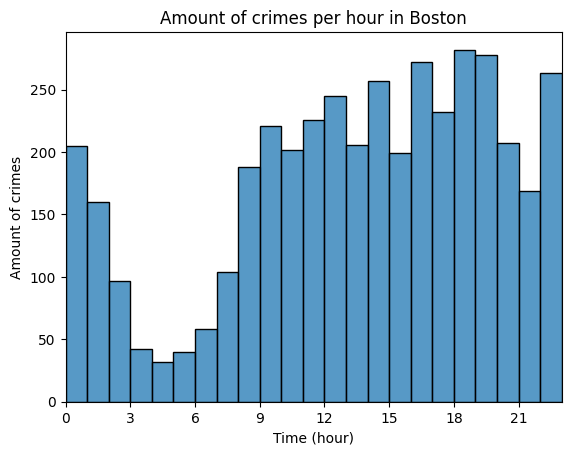

In [376]:
sns.histplot(data=crime_df, x="Hour", binwidth=1)

# Set ticks of 3 hours on x axis
ax = plt.gca()
ax.set_xlim(0, 23)
ax.set_xticks(range(0, 24, 3))

# Add title and axis names
plt.title("Amount of crimes per hour in Boston")
plt.xlabel("Time (hour)")
plt.ylabel("Amount of crimes")
plt.show()

👉 Using an histogram seems pertinent here as we just need to count values groupped by a numeric value which is our time. We should try the same with the days.

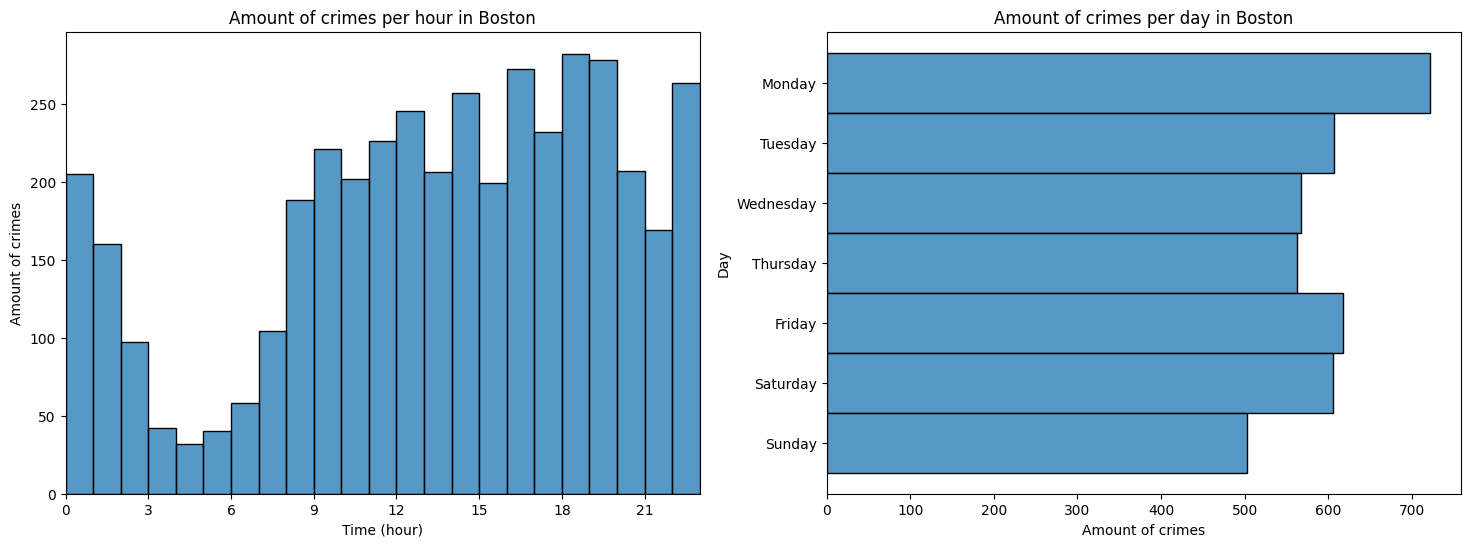

In [377]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=crime_df, x="Hour", binwidth=1, ax=axs[0])

# Set ticks of 3 hours on x axis
axs[0].set_xlim(0, 23)
axs[0].set_xticks(range(0, 24, 3))

# Add title and axis names
axs[0].set_xlabel("Time (hour)")
axs[0].set_ylabel("Amount of crimes")
axs[0].set_title("Amount of crimes per hour in Boston")

sns.histplot(data=crime_df, y="Day", ax=axs[1])

# Add title and axis names
axs[1].set_title("Amount of crimes per day in Boston")
axs[1].set_xlabel("Amount of crimes")
axs[1].set_ylabel("Day")
plt.show()

💡 Crimes tend to happen more during the afternoon, between 4pm and 8pm. We can also observe that crimes happen more on Mondays.

## 2. 🚨 What are the most frequent crimes in Boston ?
---

Histograms are also quite useful to measure the frequency of a value across a DataFrame, let's try with one.

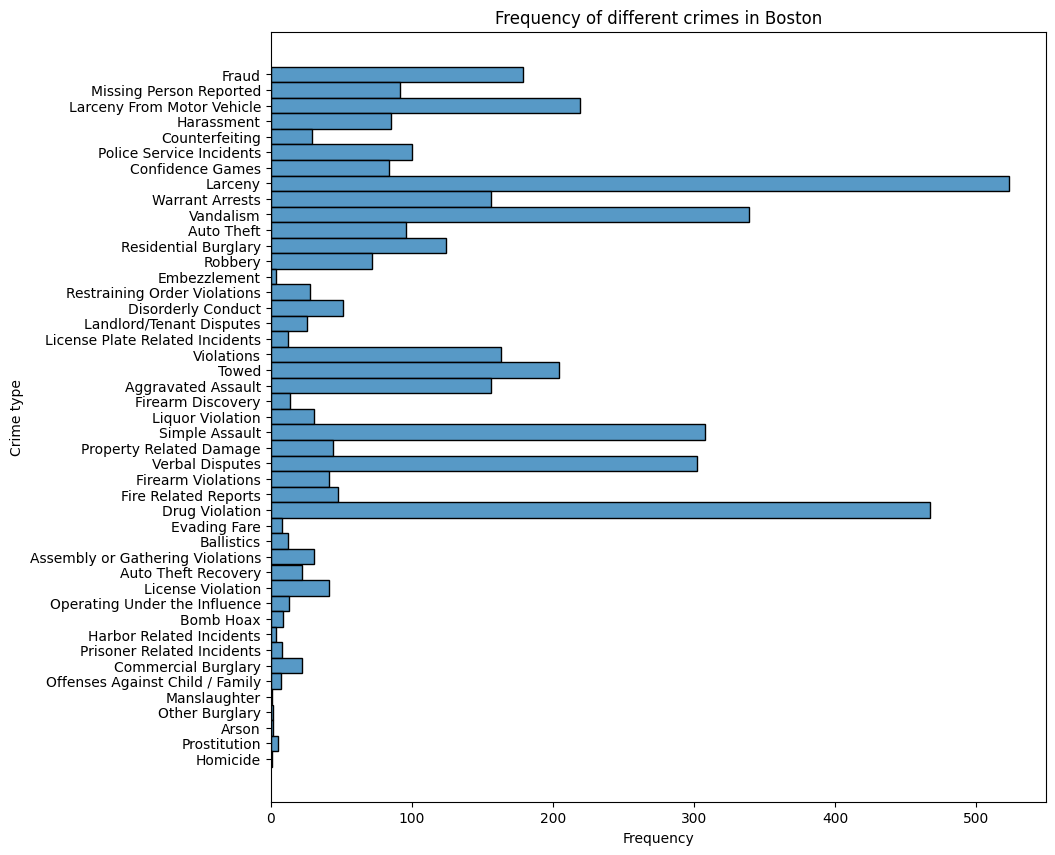

In [378]:
plt.figure(figsize=(10, 10))

sns.histplot(data=crime_df, y="Object", stat="frequency", binwidth=1)

# Set title and axis names
plt.title("Frequency of different crimes in Boston")
plt.ylabel("Crime type")
plt.show()

👉 There are too much crime types for us to make a meaningful analysis, let's take the 10 most frequent crime types instead.

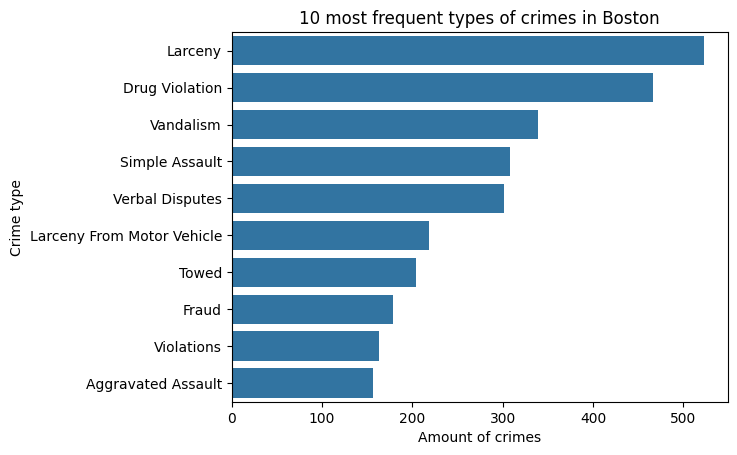

In [379]:
# Create a new DataFrame with the top 10 crime types
top_crime_types = crime_df.groupby("Object").size().nlargest(10).index
top_crimes_df = crime_df.loc[df["Object"].isin(top_crime_types)]

sns.countplot(data=top_crimes_df, y="Object", order=top_crimes_df["Object"].value_counts().index)

# Set title and axis names
plt.title("10 most frequent types of crimes in Boston")
plt.xlabel("Amount of crimes")
plt.ylabel("Crime type")
plt.show()

💡 Obviously, the most frequent crimes in Boston are larceny drug diolation and vandalism.

## 🗺️ 3. Visualize using a map the amount of crimes depending their locations.
---

For this part, we will use `folium` and its `heatmap` to visualize crimes depending their locations.

### ⏬ 3.1 Dataset reduction
---

To make our map readable as we have more than 4000 elements in our DataFrame, we will use the KMeans algorithm to clusterize our locations and display them on our map. The elbow method can help us finding the good amount of clusters.

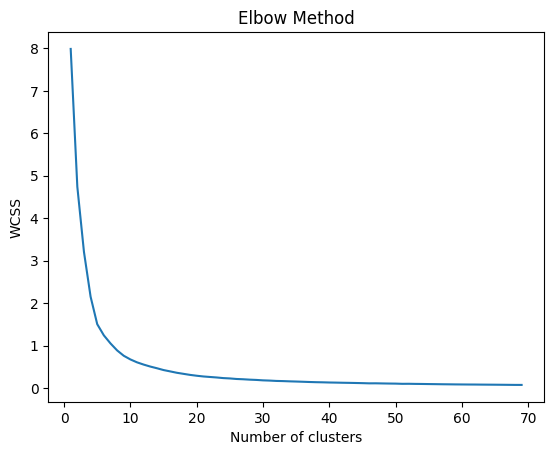

In [470]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 70):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(crime_df[["Latitude", "Longitude"]])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 70), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

👉 This method tells us to use around 5 clusters to have the best performance and results. For our behavior, we will use 50 clusters to have a more readable map.

In [471]:
from collections import Counter

locations = crime_df[["Latitude", "Longitude"]]

# Instanciate KMeans algorithme to reduce the amount of spots on our heatmap
kmeans = KMeans(n_clusters=50, init="k-means++", max_iter=300, random_state=0)
kmeans.fit(locations)
label_counts = Counter(kmeans.labels_)

weights = [[*kmeans.cluster_centers_[i], label_counts[kmeans.labels_[i]]] for i in range(len(kmeans.cluster_centers_))]

# Compute mean location to center the map
mean_location = (crime_df["Latitude"].mean(), crime_df["Longitude"].mean())
map = folium.Map(location=mean_location, zoom_start=12)

HeatMap(weights).add_to(map)

map